In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using PyPlot
using ForwardDiff
using RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
const MOI = MathOptInterface;
include("quadratic_cost.jl")
include("walker.jl")
include("utils.jl")

 Activating environment at `~/Classes/OptimalControl/hw4_solutions/Project.toml`
 Activating environment at `~/Classes/OptimalControl/hw4_solutions/Project.toml`


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-10898276164975573786\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12965589097999995381\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-10898276164975573786\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

slerp (generic function with 1 method)

# Q2: Hybrid Trajectory Optimization

In [28]:
"""
    HybridNLP{n,m,L,Q}

Represents a (N)on(L)inear (P)rogram of a trajectory optimization problem,
with a dynamics model of type `L`, a quadratic cost function, horizon `T`, 
and initial and final state `x0`, `xf`.

The kth state and control can be extracted from the concatenated state vector `Z` using
`Z[nlp.xinds[k]]`, and `Z[nlp.uinds[k]]`.

# Constructor
    NLP(model, obj, tf, T, x0, xf, [integration])

# Basic Methods
    Base.size(nlp)    # returns (n,m,T)
    num_ineq(nlp)     # number of inequality constraints
    num_eq(nlp)       # number of equality constraints
    num_primals(nlp)  # number of primal variables
    num_duals(nlp)    # total number of dual variables
    packZ(nlp, X, U)  # Stacks state `X` and controls `U` into one vector `Z`

# Evaluating the NLP
The NLP supports the following API for evaluating various pieces of the NLP:

    eval_f(nlp, Z)         # evaluate the objective
    grad_f!(nlp, grad, Z)  # gradient of the objective
    hess_f!(nlp, hess, Z)  # Hessian of the objective
    eval_c!(nlp, c, Z)     # evaluate the constraints
    jac_c!(nlp, c, Z)      # constraint Jacobian
"""
struct HybridNLP{n,m,L,Q} <: MOI.AbstractNLPEvaluator
    model::L                                 # dynamics model
    obj::Vector{QuadraticCost{n,m,Float64}}  # objective function
    T::Int                                   # number of knot points
    M::Int                                   # number of steps in each mode
    Nmodes::Int                              # number of modes
    tf::Float64                              # total time (sec)
    x0::MVector{n,Float64}                   # initial condition
    xf::MVector{n,Float64}                   # final condition
    times::Vector{Float64}                   # vector of times
    modes::Vector{Int}                       # mode ID
    xinds::Vector{SVector{n,Int}}            # Z[xinds[k]] gives states for time step k
    uinds::Vector{SVector{m,Int}}            # Z[uinds[k]] gives controls for time step k
    cinds::Vector{UnitRange{Int}}
    lb::Vector{Float64}
    ub::Vector{Float64}
    function HybridNLP(model, obj::Vector{<:QuadraticCost{n,m}},
            tf::Real, T::Integer, M::Integer, x0::AbstractVector, xf::AbstractVector, integration::Type{<:QuadratureRule}=RK4
        ) where {n,m}
        xinds = [SVector{n}((k-1)*(n+m) .+ (1:n)) for k = 1:T]
        uinds = [SVector{m}((k-1)*(n+m) .+ (n+1:n+m)) for k = 1:T-1]
        times = collect(range(0, tf, length=T))
        modes = map(1:T) do k
            isodd((k-1) ÷ M + 1) ? 1 : 2
        end
        Nmodes = Int(ceil(T/M))
        
        c_init_inds = 1:n                                                    # initial constraint
        c_term_inds = (c_init_inds[end]+1):(c_init_inds[end]+n)              # terminal constraint
        c_dyn_inds = (c_term_inds[end]+1):(c_term_inds[end]+n*(T-1)  )       # dynamics constraints
        c_stance_inds = (c_dyn_inds[end]+1):(c_dyn_inds[end]+T)              # stance constraint (1 per time step)
        c_length_inds = (c_stance_inds[end]+1):(c_stance_inds[end]+(2*T))    # length bounds     (2 per time step)
        m_nlp = c_length_inds[end]                                           # total number of constraints
        
        lb = fill(0.0,m_nlp)
        ub = fill(0.0,m_nlp)
        lb[c_length_inds] .= model.ℓ_min
        ub[c_length_inds] .= model.ℓ_max

        cinds = [c_init_inds, c_term_inds, c_dyn_inds, c_stance_inds, c_length_inds]
        
        new{n,m,typeof(model), integration}(
            model, obj,
            T, M, Nmodes, tf, x0, xf, times, modes,
            xinds, uinds, cinds, lb, ub
        )
    end
end
Base.size(nlp::HybridNLP{n,m}) where {n,m} = (n,m,nlp.T)
num_primals(nlp::HybridNLP{n,m}) where {n,m} = n*nlp.T + m*(nlp.T-1)
num_duals(nlp::HybridNLP) = nlp.cinds[end][end]

"""
    packZ(nlp, X, U)

Take a vector state vectors `X` and controls `U` and stack them into a single vector Z.
"""
function packZ(nlp, X, U)
    Z = zeros(num_primals(nlp))
    for k = 1:nlp.T-1
        Z[nlp.xinds[k]] = X[k]
        Z[nlp.uinds[k]] = U[k]
    end
    Z[nlp.xinds[end]] = X[end]
    return Z
end

"""
    unpackZ(nlp, Z)

Take a vector of all the states and controls and return a vector of state vectors `X` and
controls `U`.
"""
function unpackZ(nlp, Z)
    X = [Z[xi] for xi in nlp.xinds]
    U = [Z[ui] for ui in nlp.uinds]
    return X, U
end

include("moi.jl")

solve (generic function with 1 method)

## Costs

In [3]:
"""
    eval_f(nlp, Z)

Evaluate the objective, returning a scalar.
"""
function eval_f(nlp::HybridNLP, Z)
    # TASK: compute the objective value (cost)
    J = 0.0
    
    # SOLUTION
    xi,ui = nlp.xinds, nlp.uinds
    for k = 1:nlp.T-1
        x,u = Z[xi[k]], Z[ui[k]]
        J += stagecost(nlp.obj[k], x, u)
    end
    J += termcost(nlp.obj[end], Z[xi[end]])
    return J
end

"""
    grad_f!(nlp, grad, Z)

Evaluate the gradient of the objective at `Z`, storing the result in `grad`.
"""
function grad_f!(nlp::HybridNLP{n,m}, grad, Z) where {n,m}
    xi,ui = nlp.xinds, nlp.uinds
    obj = nlp.obj
    for k = 1:nlp.T-1
        x,u = Z[xi[k]], Z[ui[k]]
        # TASK: Compute the cost gradient
        grad[xi[k]] .= 0
        grad[ui[k]] .= 0
        
        # SOLUTION
        grad[xi[k]] = obj[k].Q*x + obj[k].q
        grad[ui[k]] = obj[k].R*u + obj[k].r
    end
    grad[xi[end]] = obj[end].Q*Z[xi[end]] + obj[end].q
    return nothing
end

"""
    hess_f!(nlp, hess, Z)

Evaluate the Hessian of the objective at `Z`, storing the result in `hess`.
Should work with `hess` sparse.
"""
function hess_f!(nlp::HybridNLP{n,m}, hess, Z, rezero=true) where {n,m}
    # TASK: Compute the objective hessian
    # HINT: It's a diagonal matrix
    if rezero
        for i = 1:size(hess,1)
            hess[i,i] = 0
        end
    end
    xi,ui = nlp.xinds, nlp.uinds
    obj = nlp.obj
    i = 1
    for k = 1:nlp.T
        for j = 1:n
            hess[i,i] += nlp.obj[k].Q[j,j]
            i += 1
        end
        if k < nlp.T
            for j = 1:m
                hess[i,i] += nlp.obj[k].R[j,j]
                i += 1
            end
        end
    end
end

hess_f!

## Constraints

In [9]:
"""
    eval_c!(nlp, c, Z)

Evaluate the equality constraints at `Z`, storing the result in `c`.
The constraints should be ordered as follows: 
1. Initial condition ``x_1 = x_\\text{init}``
2. Dynamics ``f(x_k,u_k) - x_{k+1} = 0``
3. Terminal constraint ``x_T = x_\\text{goal}``

For this problem, you can use an explicit integrator. We suggest RK4.
"""
function dyn!(nlp::HybridNLP{n,m,<:Any,Q}, c, Z) where {n,m,Q}
    T = nlp.T
    xi,ui = nlp.xinds, nlp.uinds
    idx = xi[1]

    # TODO: initial condition
    c[idx] = Z[xi[1]] - nlp.x0

    # dynamics
    for k = 1:T-1
        idx = idx .+ n
        x,u = Z[xi[k]], Z[ui[k]]
        x⁺ = Z[xi[k+1]]
        dt = nlp.times[k+1] - nlp.times[k]
        
        # TASK: Dynamics constraint
        c[idx] .= 0
        
        # SOLUTION
        c[idx] = discrete_dynamics(Q, nlp.model, x, u, nlp.times[k], dt) - x⁺
    end

    # TODO: terminal constraint
    idx = idx .+ n
    c[idx] .= 0
    
    # SOLUTION
    c[idx] = Z[xi[T]] - nlp.xf
    return nothing
end

function dynamics_constraint!(nlp::HybridNLP{n,m}, c, Z) where {n,m}
    model = nlp.model
    d = view(c, nlp.cinds[3])
    xi,ui = nlp.xinds, nlp.uinds
    ci = 1:n
    for k = 1:nlp.T-1
        x,u   = Z[xi[k]],   Z[ui[k]]
        x2    = Z[xi[k+1]]
        dk = view(d,ci)
        t = nlp.times[k]
        dt = nlp.times[k+1] - nlp.times[k]
        
        mode = nlp.modes[k]
        
        
#         if nlp.modes[k] == 1
#             dk .= stance1_dynamics_rk4(x, u) - x2
#         else
#             dk .= stance2_dynamics_rk4(x, u) - x2
#         end
        jump = nlp.modes[k+1] != nlp.modes[k]
        f = rk4(model, x, u, t, dt, mode)
        if jump
            dk .= jumpmap(model, f, mode) - x2
#             if nlp.modes[k] == 1
#                 dk .= jump2_map(dk + x2) - x2
#             else
#                 dk .= jump1_map(dk + x2) - x2
#             end
        else
            dk .= f - x2
        end
        
        ci = ci .+ n
    end
    
    return d
end

function dynamics_jacobian!(nlp::HybridNLP{n,m}, jac, Z) where {n,m}
    model = nlp.model
    D = view(jac, nlp.cinds[3], :)
    xi,ui = nlp.xinds, nlp.uinds
    ci = 1:n
    for k = 1:nlp.T-1
        x,u   = Z[xi[k]],   Z[ui[k]]
        zi = [xi[k]; ui[k]]
        t = nlp.times[k]
        dt = nlp.times[k+1] - nlp.times[k]
        
        mode = nlp.modes[k]
        jump = nlp.modes[k+1] != nlp.modes[k]
        function dyn(z)
            x2 = rk4(model, z[xi[1]], z[ui[1]], t, dt, mode)
            jump ? jumpmap(model, x2, mode) : x2
        end
        F = view(D, ci, zi)
        F2 = view(D, ci, xi[k+1])
        
        ForwardDiff.jacobian!(F, 
            dyn,
            [x; u]
        )
        for i = 1:n
            F2[i,i] = -1
        end
        ci = ci .+ n
    end
end

function stance_constraint!(nlp::HybridNLP, c, Z)
    d = view(c, nlp.cinds[4])
    xi,ui = nlp.xinds, nlp.uinds
    t = 1
    for k = 1:nlp.T
        x = Z[xi[k]]
        foot_ind = nlp.modes[k] == 1 ? 4 : 6 
        d[t] = x[foot_ind]   # keep foot on the floor 
        t += 1
    end
    return d
end

function length_constraint!(nlp::HybridNLP, c, Z)
    d = view(c, nlp.cinds[5])
    xi,ui = nlp.xinds, nlp.uinds
    for k = 1:nlp.T
        x = Z[xi[k]]
        d[2*(k-1)+1] = norm(x[1:2] - x[3:4])
        d[2*(k-1)+2] = norm(x[1:2] - x[5:6])
    end
    return d
end

function eval_c!(nlp::HybridNLP, c, Z)
    xi,ui = nlp.xinds, nlp.uinds
    c[nlp.cinds[1]] .= Z[xi[1]] - nlp.x0
    c[nlp.cinds[2]] .= Z[xi[end]] - nlp.xf
    dynamics_constraint!(nlp, c, Z)
    stance_constraint!(nlp, c, Z)
    length_constraint!(nlp, c, Z)
end

function jac_c!(nlp::HybridNLP{n,m}, jac, Z) where {n,m}
    xi,ui = nlp.xinds, nlp.uinds
    m_nlp = size(jac,1)
    Finit = view(jac, nlp.cinds[1], xi[1])
    Fterm = view(jac, nlp.cinds[2], xi[end])
    for i = 1:n
        Finit[i,i] = 1
        Fterm[i,i] = 1
    end
    
    dynamics_jacobian!(nlp, jac, Z)
    jac_stance = ForwardDiff.jacobian(
        z->stance_constraint!(nlp, zeros(eltype(z), m_nlp), z),
        Z
    )
    jac_length = ForwardDiff.jacobian(
        z->length_constraint!(nlp, zeros(eltype(z), m_nlp), z),
        Z
    )
    jac[nlp.cinds[4],:] .= jac_stance
    jac[nlp.cinds[5],:] .= jac_length
    
end

jac_c! (generic function with 1 method)

## Problem Definition

In [5]:
# Dynamics model
model = SimpleWalker()

# Discretization
tf = 4.4
dt = 0.1
T = Int(ceil(tf/dt)) + 1
M = 5
times = range(0,tf, length=T)

# model = Walker()
# nlp = HybridNLP(model, obj, thist[end], T, M, xref[:,1], xref[:,end]);

## Reference Trajectory

In [6]:
function reference_trajectory(model::SimpleWalker, times)
    n,m = size(model)
    tf = times[end]
    T = length(times)
    mb,g = model.mb, model.g
    uref = [0.5*mb*g; 0.5*mb*g; 0.0]
    xref = zeros(n,T)
    xref[1,:] .= LinRange(-1.5,1.5,T)
    xref[2,:] .= ones(T)
    xref[3,:] .= LinRange(-1.5,1.5,T)
    xref[5,:] .= LinRange(-1.5,1.5,T)
    xref[7,2:end-1] .= (3.0/tf)*ones(T-2)
    xref[9,2:end-1] .= (3.0/tf)*ones(T-2)
    xref[11,2:end-1] .= (3.0/tf)*ones(T-2);  
    Uref = [SVector{m}(uref) for k = 1:T-1]
    Xref = [SVector{n}(x) for x in eachcol(xref)]
    return Xref, Uref
end
Xref,Uref = reference_trajectory(model, times);

## Solve


In [30]:
# Objective
using Random
Random.seed!(1)
Q = Diagonal([1.0*ones(6); 1.0*ones(6)]);
R = Diagonal(fill(1e-3,3))
Qf = Q;
obj = map(1:T-1) do k
    LQRCost(Q,R,Xref[k],Uref[k])
end
push!(obj, LQRCost(Qf, R*0, Xref[T], Uref[1]))

# Define the NLP
nlp = HybridNLP(model, obj, tf, T, M, Xref[1], Xref[end]);

# Initial guess
Xguess = [x + 0.1*randn(length(x)) for x in Xref]
Uguess = [u + 0.1*randn(length(u)) for u in Uref]
Z0 = packZ(nlp, Xguess, Uguess);

In [31]:
# include("moi.jl")
Z_sol, solver = solve(Z0, nlp)

Creating NLP Block Data...
Creating Ipopt...
Adding constraints...
starting Ipopt Solve...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   401184
Number of nonzeros in inequality constraint Jacobian.:    60480
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      672
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      597
Total number of inequality constraints...............:       90
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       90
        inequality constraints with only upper bounds:       

([-1.4702712015464539, 1.0382395967790607, -1.559763447672823, -0.001044524463737564, -1.5839026854388765, 0.031111133849833383, 0.22950878238373107, -0.22670863488005308, 0.052996557616674614, 0.04314215264229121  …  1.667594880878731, -0.015215554740698257, 1.5266660230841296, -0.06686180415998987, -0.03688296792504201, -0.03013920467592153, 0.006677792368156305, -0.05088012947039371, -0.03523456900970411, 0.02886881322327386], Ipopt.Optimizer)

In [32]:
MOI.optimize!(solver)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   401184
Number of nonzeros in inequality constraint Jacobian.:    60480
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      672
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      597
Total number of inequality constraints...............:       90
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       90
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [157]:
Z = randn(n_nlp)

@show MOI.eval_objective(prob, Z) ≈ MOI.eval_objective(nlp, Z)

grad_f1 = zero(Z)
grad_f2 = zero(Z)
MOI.eval_objective_gradient(prob, grad_f1, Z) 
MOI.eval_objective_gradient(nlp,  grad_f2, Z)
@show norm(grad_f1 - grad_f2)

c1 = zeros(m_nlp)
c2 = zeros(m_nlp)
MOI.eval_constraint(prob, c1, Z)
MOI.eval_constraint(nlp,  c2, Z)
@show norm(c1 - c2)

jac1 = zeros(m_nlp, n_nlp)
jac2 = zeros(m_nlp, n_nlp)
MOI.eval_constraint_jacobian(prob, vec(jac1), Z)
MOI.eval_constraint_jacobian(prob, vec(jac2), Z)
@show norm(jac1 - jac2)

@show norm.(prob.constraint_bounds .- (nlp.lb, nlp.ub))
prob.primal_bounds

MOI.eval_objective(prob, Z) ≈ MOI.eval_objective(nlp, Z) = true
norm(grad_f1 - grad_f2) = 1.9317063097816575e-17
norm(c1 - c2) = 1.799075887679826e-14
norm(jac1 - jac2) = 0.0
norm.(prob.constraint_bounds .- (nlp.lb, nlp.ub)) = (0.0, 0.0)


([-Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf  …  -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf])

## Visualizer

In [11]:
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("Rfoot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x52, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"torso" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Laxle" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x4c, 0x61, 0x78, 0x6c, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x4c, 0x61, 0x78, 0x6c, 0x65], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Lleg" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4c, 0x6c, 0x65, 0x67, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"Rleg" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x52, 0x6c, 0x65, 0x67, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"Raxle" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x52, 0x61, 0x78, 0x6c, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x52, 0x61, 0x78, 0x6c, 0x65], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"Lfoot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x4c, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [23]:
visualize!(vis, nlp, unpackZ(nlp, Z_sol)[1])

# Old Problem

In [33]:
Nx = 12         # number of state
Nu = 3          # number of controls
Tfinal = 4.4    # final time
h = 0.1         # 10 hz
Nm = 5          # number of steps in each mode
Nt = Int(ceil(Tfinal/h)+1)   # number of time steps
Nmodes = Int(ceil(Nt/Nm))
thist = Array(range(0,h*(Nt-1), step=h));
n_nlp = Nx*Nt + Nu*(Nt-1) # number of decision variables
c_init_inds = 1:Nx                                                   # initial constraint
c_term_inds = (c_init_inds[end]+1):(c_init_inds[end]+Nx)             # terminal constraint
c_dyn_inds = (c_term_inds[end]+1):(c_term_inds[end]+Nx*(Nt-1))       # dynamics constraints
c_stance_inds = (c_dyn_inds[end]+1):(c_dyn_inds[end]+Nt)             # stance constraint (1 per time step)
c_length_inds = (c_stance_inds[end]+1):(c_stance_inds[end]+(2*Nt))   # length bounds     (2 per time step)
m_nlp = c_length_inds[end]                                           # total constraints
cinds = [c_init_inds, c_term_inds, c_dyn_inds, c_stance_inds, c_length_inds]

5-element Array{UnitRange{Int64},1}:
 1:12
 13:24
 25:552
 553:597
 598:687

In [34]:
#Walker Dynamics
Base.@kwdef struct Walker
    g::Float64 = 9.81
    mb::Float64 = 5.0
    mf::Float64 = 1.0
    ℓ_min::Float64 = 0.5
    ℓ_max::Float64 = 1.5
end
RobotDynamics.state_dim(::Walker) = 12
RobotDynamics.control_dim(::Walker) = 3
g = 9.81
mb = 5.0 #body mass
mf = 1.0 #foot mass
ℓ_min = 0.5 #minimum length
ℓ_max = 1.5 #maximum length

function stance1_dynamics(x,u)
    #Foot 1 is in contact
    M = Diagonal([mb mb mf mf mf mf])
    
    rb  = x[1:2]   # position of the body
    rf1 = x[3:4]   # position of foot 1
    rf2 = x[5:6]   # position of foot 2
    v   = x[7:12]  # velocities
    
    ℓ1x = (rb[1]-rf1[1])/norm(rb-rf1)
    ℓ1y = (rb[2]-rf1[2])/norm(rb-rf1)
    ℓ2x = (rb[1]-rf2[1])/norm(rb-rf2)
    ℓ2y = (rb[2]-rf2[2])/norm(rb-rf2)
    
    B = [ℓ1x  ℓ2x  ℓ1y-ℓ2y;
         ℓ1y  ℓ2y  ℓ2x-ℓ1x;
          0    0     0;
          0    0     0;
          0  -ℓ2x  ℓ2y;
          0  -ℓ2y -ℓ2x]
    
    v̇ = [0; -g; 0; 0; 0; -g] + M\(B*u)
    
    ẋ = [v; v̇]
end

function stance2_dynamics(x,u)
    #Foot 2 is in contact
    M = Diagonal([mb mb mf mf mf mf])
    
    rb  = x[1:2]
    rf1 = x[3:4]
    rf2 = x[5:6]
    v   = x[7:12]
    
    ℓ1x = (rb[1]-rf1[1])/norm(rb-rf1)
    ℓ1y = (rb[2]-rf1[2])/norm(rb-rf1)
    ℓ2x = (rb[1]-rf2[1])/norm(rb-rf2)
    ℓ2y = (rb[2]-rf2[2])/norm(rb-rf2)
    
    B = [ℓ1x  ℓ2x  ℓ1y-ℓ2y;
         ℓ1y  ℓ2y  ℓ2x-ℓ1x;
        -ℓ1x   0  -ℓ1y;
        -ℓ1y   0   ℓ1x;
          0    0    0;
          0    0    0]
    
    v̇ = [0; -g; 0; -g; 0; 0] + M\(B*u)
    
    ẋ = [v; v̇]
end

function stance1_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = stance1_dynamics(x, u)
    f2 = stance1_dynamics(x + 0.5*h*f1, u)
    f3 = stance1_dynamics(x + 0.5*h*f2, u)
    f4 = stance1_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

function stance2_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = stance2_dynamics(x, u)
    f2 = stance2_dynamics(x + 0.5*h*f1, u)
    f3 = stance2_dynamics(x + 0.5*h*f2, u)
    f4 = stance2_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

function jump1_map(x)
    #Foot 1 experiences inelastic collision
    xn = [x[1:8]; 0.0; 0.0; x[11:12]]
    return xn
end

function jump2_map(x)
    #Foot 2 experiences inelastic collision
    xn = [x[1:10]; 0.0; 0.0]
    return xn
end

jump2_map (generic function with 1 method)

In [35]:
# Cost weights
Q = Diagonal([1.0*ones(6); 1.0*ones(6)]);
R = 0.001;
R = Diagonal(fill(1e-3,3))
Qn = Q;

In [36]:
function stage_cost(x,u,k)
    return 0.5*((x-xref[:,k])'*Q*(x-xref[:,k])) + 0.5*(u-uref)'*R*(u-uref)
end
function terminal_cost(x)
    return 0.5*((x-xref[:,end])'*Qn*(x-xref[:,end]))
end

terminal_cost (generic function with 1 method)

In [40]:
function cost(ztraj)
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = [z[1:Nx,:] ztraj[end-(Nx-1):end]]
    utraj = z[(Nx+1):(Nx+Nu),:]
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[:,k],k)
    end
    J += terminal_cost(xtraj[:,end])
    return J
end

cost (generic function with 2 methods)

In [41]:
#Reference Trajectory
uref = [0.5*mb*g; 0.5*mb*g; 0.0]
xref = zeros(Nx,Nt)
xref[1,:] .= LinRange(-1.5,1.5,Nt)
xref[2,:] .= ones(Nt)
xref[3,:] .= LinRange(-1.5,1.5,Nt)
xref[5,:] .= LinRange(-1.5,1.5,Nt)
xref[7,2:end-1] .= (3.0/Tfinal)*ones(Nt-2)
xref[9,2:end-1] .= (3.0/Tfinal)*ones(Nt-2)
xref[11,2:end-1] .= (3.0/Tfinal)*ones(Nt-2);

In [42]:
function dynamics_constraint!(c,ztraj)
    d = reshape(view(c,c_dyn_inds),Nx,Nt-1)
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = [z[1:Nx,:] ztraj[end-(Nx-1):end]]
    utraj = z[(Nx+1):(Nx+Nu),:]
    for k = 1:(Nmodes-1)
        if mod(k,2) == 1
            for j = 1:(Nm-1)
                s = (k-1)*Nm + j
                d[:,s] = stance1_dynamics_rk4(xtraj[:,s],utraj[:,s]) - xtraj[:,s+1]
            end
            s = k*Nm
            d[:,s] = jump2_map(stance1_dynamics_rk4(xtraj[:,s],utraj[:,s])) - xtraj[:,s+1]
        else
            for j = 1:(Nm-1)
                s = (k-1)*Nm + j
                d[:,s] = stance2_dynamics_rk4(xtraj[:,s],utraj[:,s]) - xtraj[:,s+1]
            end
            s = k*Nm
            d[:,s] = jump1_map(stance2_dynamics_rk4(xtraj[:,s],utraj[:,s])) - xtraj[:,s+1]
        end
    end
    if mod(Nmodes,2) == 1
        for j = 1:(Nm-1)
            s = (Nmodes-1)*Nm + j
            d[:,s] = stance1_dynamics_rk4(xtraj[:,s],utraj[:,s]) - xtraj[:,s+1]
        end
    else
        for j = 1:(Nm-1)
            s = (Nmodes-1)*Nm + j
            d[:,s] = stance2_dynamics_rk4(xtraj[:,s],utraj[:,s]) - xtraj[:,s+1]
        end
    end
    
    return nothing
end

dynamics_constraint! (generic function with 2 methods)

In [43]:
function stance_constraint!(c,ztraj)
    d = view(c,c_stance_inds)
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = [z[1:Nx,:] ztraj[(end-(Nx-1)):end]]
    t = 1
    for k = 1:Nmodes
        if mod(k,2) == 1
            for j = 1:Nm
                s = (k-1)*Nm + j
                d[t] = xtraj[4,s]  # keep foot on the floor
                t += 1
            end
        else
            for j = 1:Nm
                s = (k-1)*Nm + j
                d[t] = xtraj[6,s]
                t += 1
            end
        end
            
    end
    return nothing
end

stance_constraint! (generic function with 2 methods)

In [44]:
function length_constraint!(c,ztraj)
    d = view(c,c_length_inds)
    z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
    xtraj = [z[1:Nx,:] ztraj[(end-(Nx-1)):end]]
    for k = 1:Nt
        d[2*(k-1)+1] = norm(xtraj[1:2,k] - xtraj[3:4,k])
        d[2*(k-1)+2] = norm(xtraj[1:2,k] - xtraj[5:6,k])
    end
end

length_constraint! (generic function with 2 methods)

In [45]:
function con!(c,ztraj)
    c[c_init_inds] .= ztraj[1:Nx] - xref[:,1] #initial state constraint
    c[c_term_inds] .= ztraj[(end-(Nx-1)):end] - xref[:,end] #terminal state constraint
    @views dynamics_constraint!(c,ztraj)
    @views stance_constraint!(c,ztraj)
    @views length_constraint!(c,ztraj)
end

con! (generic function with 1 method)

In [49]:
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=c_length_inds,
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    return x_l, x_u
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    c_l[idx_ineq] .= ℓ_min

    c_u = zeros(m)
    c_u[idx_ineq] .= ℓ_max
    return c_l, c_u
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res, solver
end

solve (generic function with 2 methods)

In [47]:
#Guess
xguess = xref + 0.1*randn(Nx,Nt)
uguess = kron(ones(Nt-1)', uref) + 0.1*randn(Nu,Nt-1)
z0 = [reshape([xguess[:,1:(Nt-1)]; uguess],(Nx+Nu)*(Nt-1),1); xguess[:,end]];

In [50]:
prob = ProblemMOI(n_nlp,m_nlp)
z_sol, solver = solve(z0,prob) # solve

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   401184
Number of nonzeros in inequality constraint Jacobian.:    60480
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      672
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      597
Total number of inequality constraints...............:       90
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       90
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

([-1.5000000000000002, 1.0, -1.4999999999999998, 1.245169584512821e-19, -1.5, 7.788509458426897e-18, -4.633202998445543e-17, 5.418766160932768e-18, 4.0113836452081653e-17, -7.89580936092339e-18  …  1.5000000000000002, 1.5405113407250485e-19, 1.5, 8.976325980683132e-18, 2.847614476549533e-17, 2.202335558687524e-18, -1.0129807951598129e-17, -2.0704562465486633e-19, -2.698190102401601e-18, 1.9222600376629094e-18], Ipopt.Optimizer)

In [51]:
MOI.optimize!(solver)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   401184
Number of nonzeros in inequality constraint Jacobian.:    60480
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      672
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      597
Total number of inequality constraints...............:       90
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       90
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [83]:
z = reshape(z_sol[1:(end-Nx)],Nx+Nu,Nt-1)
xtraj = [z[1:Nx,:] z_sol[end-(Nx-1):end]]
utraj = z[(Nx+1):(Nx+Nu),:];

# New Problem

unpackZ

hess_f!

eval_c! (generic function with 1 method)

In [204]:
obj = map(1:Nt-1) do k
    LQRCost(Q,R,xref[:,k],uref)
end
push!(obj, LQRCost(Qn, R*0, xref[:,Nt], uref))

model = Walker()
nlp = HybridNLP(model, obj, thist[end], Nt, Nm, xref[:,1], xref[:,end]);
Z = vec(z0)
eval_f(nlp, Z) - cost(z0)

grad1 = zero(Z)
grad2 = zero(Z)
grad_f!(nlp, grad1, Z)
MOI.eval_objective_gradient(prob, grad2, Z)
grad1 ≈ grad2

c1 = zeros(m_nlp)
c2 = zeros(m_nlp)
Z = rand(n_nlp)
dynamics_constraint!(nlp, c1, Z)
dynamics_constraint!(c2, Z)

stance_constraint!(nlp, c1, Z)
stance_constraint!(c2, Z)

length_constraint!(nlp, c1, Z)
length_constraint!(c2, Z)

Z = rand(n_nlp)
eval_c!(nlp, c1, Z)
con!(c2, Z)

inds = findall(.!(c1 .≈ c2))
num_primals(nlp) == n_nlp
num_duals(nlp) == m_nlp

nlp.lb == constraint_bounds(m_nlp, idx_ineq=c_length_inds)[1]
nlp.ub == constraint_bounds(m_nlp, idx_ineq=c_length_inds)[2]

true

solve (generic function with 2 methods)

In [229]:
xguess = xref + 0.1*randn(Nx,Nt)
uguess = kron(ones(Nt-1)', uref) + 0.1*randn(Nu,Nt-1)
Z0 = [reshape([xguess[:,1:(Nt-1)]; uguess],(Nx+Nu)*(Nt-1),1); xguess[:,end]];
Z_sol = solve(Z0, nlp)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   401184
Number of nonzeros in inequality constraint Jacobian.:    60480
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      672
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      597
Total number of inequality constraints...............:       90
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       90
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

672-element Array{Float64,1}:
 -1.5
  1.0
 -1.5000000000000002
  2.6751457627817306e-19
 -1.5
  3.621349315170559e-18
  3.0843238410266e-17
  4.390720728949824e-19
 -3.008998589109138e-17
  3.523901260719566e-19
  3.577890326219869e-18
 -2.2918810086306415e-18
 77.66672528256782
  ⋮
  1.5000000000000007
  1.0
  1.4999999999999991
 -7.096174606744433e-19
  1.5000000000000002
 -3.972527408648526e-17
 -1.889449707898512e-16
 -3.544031592309081e-18
  6.851133065599962e-17
  8.873147322170609e-19
 -9.420170166218907e-18
 -1.5344690220149927e-18

In [230]:
Xsol,Usol = unpackZ(nlp, Z_sol)
xtraj = hcat(Vector.(Xsol)...)
utraj = hcat(Vector.(Usol)...)

3×44 Array{Float64,2}:
  77.6667   94.5436   102.675   102.493   …   90.831     94.9979   96.8012
 -54.4169  -58.3776   -59.0506  -34.4255     -52.4596   -48.6534  -47.1428
  78.0405    4.10058  -16.5639  -19.3055       6.37202  -16.1864  -55.2958

# Results

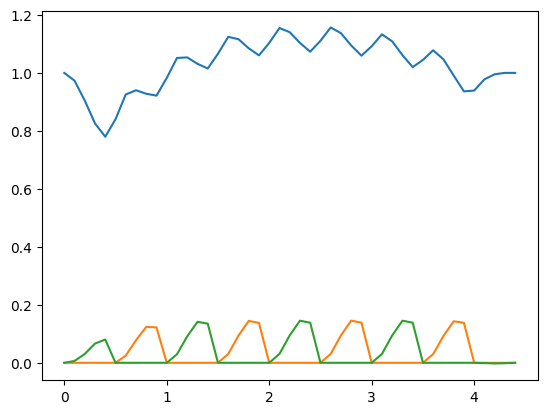

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f79d8333610>

In [231]:
plot(thist,xtraj[2,:])
plot(thist,xtraj[4,:])
plot(thist,xtraj[6,:])

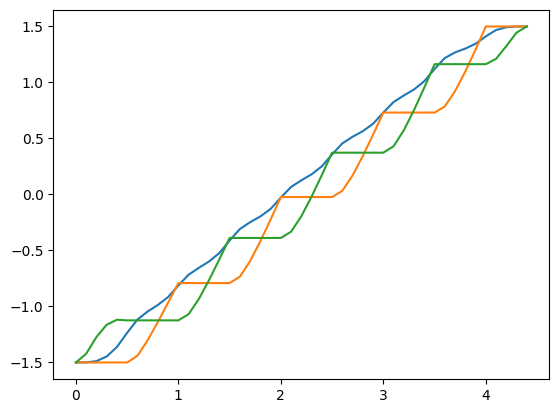

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f79d83130a0>

In [232]:
plot(thist,xtraj[1,:])
plot(thist,xtraj[3,:])
plot(thist,xtraj[5,:])

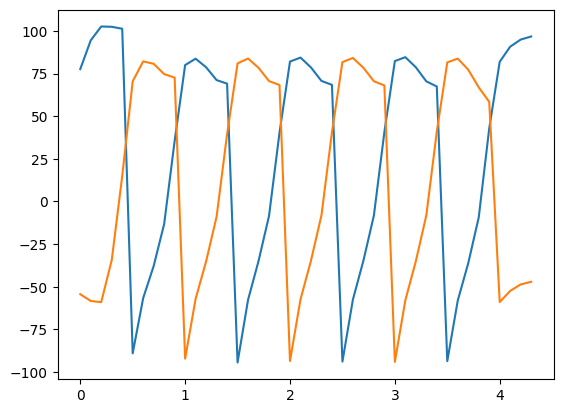

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f79d826a730>

In [233]:
plot(thist[1:end-1],utraj[1,:])
plot(thist[1:end-1],utraj[2,:])

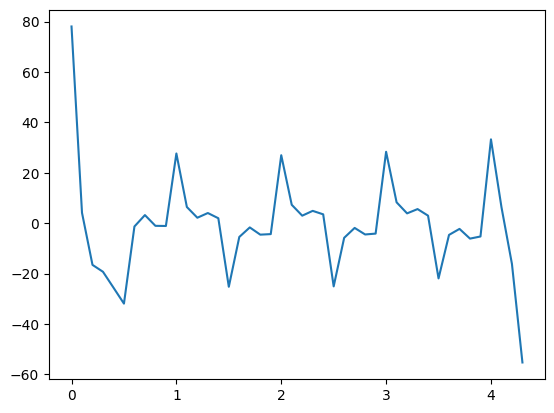

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f79d82484c0>

In [234]:
plot(thist[1:end-1],utraj[3,:])

In [235]:
#Set up visualizer
using Colors
using CoordinateTransformations
using GeometryBasics
using MeshCat
using Rotations
using StaticArrays

# Visualization
function set_mesh!(vis)
    l,w,h = 0.4,0.4,0.6
    body = HyperRectangle(Vec(-l/2,-w/2,0), Vec(l,w,h)) 
    body = Sphere(Point3f0(0,0,0), 7l/16)
    setobject!(vis["robot"]["torso"]["body"], body, MeshPhongMaterial(color=colorant"gray"))
    axle = Cylinder(Point3f0(0,0,0), Point3f0(0,w/2,0), 0.03f0)
    setobject!(vis["robot"]["torso"]["Laxle"], axle, MeshPhongMaterial(color=colorant"black"))
    setobject!(vis["robot"]["torso"]["Raxle"], axle, MeshPhongMaterial(color=colorant"black"))
    settransform!(vis["robot"]["torso"]["Laxle"], Translation(0,+l/4,0))
    settransform!(vis["robot"]["torso"]["Raxle"], Translation(0,-3l/4,0))

    foot = HyperSphere(Point3f0(0,0,0f0), 0.05f0)
    Lfoot = setobject!(vis["robot"]["Lfoot"]["geom"], foot, MeshPhongMaterial(color=colorant"firebrick"))
    setobject!(vis["robot"]["Rfoot"]["geom"], foot, MeshPhongMaterial(color=colorant"firebrick"))
    settransform!(vis["robot"]["Lfoot"]["geom"], Translation(0,+l/2,0))
    settransform!(vis["robot"]["Rfoot"]["geom"], Translation(0,-l/2,0))

    Lleg = Cylinder(Point3f0(0,+l/2,0), Point3f0(0,+l/2,1), 0.03f0)
    Rleg = Cylinder(Point3f0(0,-l/2,0), Point3f0(0,-l/2,1), 0.03f0)
    setobject!(vis["robot"]["torso"]["Lleg"]["geom"], Lleg, MeshPhongMaterial(color=colorant=colorant"green"))
    setobject!(vis["robot"]["torso"]["Rleg"]["geom"], Rleg, MeshPhongMaterial(color=colorant=colorant"green"))
    # settransform!(vis["robot"]["torso"]["Lleg"]["geom"], Translation(0,+l/2,0))
    # settransform!(vis["robot"]["torso"]["Rleg"]["geom"], Translation(0,-l/2,0))

    return Lfoot
end

function visualize!(vis, x::StaticVector)
    xb,yb = x[1],x[2]
    xl,yl = x[3],x[4]
    xr,yr = x[5],x[6]
    settransform!(vis["robot"]["torso"], Translation(xb,0,yb))
    settransform!(vis["robot"]["Lfoot"], Translation(xl,0,yl))
    settransform!(vis["robot"]["Rfoot"], Translation(xr,0,yr))

    Llen = norm(SA[xl-xb, yl-yb])
    Rlen = norm(SA[xr-xb, yr-yb])
    θl = atan(xl-xb, yl-yb)
    θr = atan(xr-xb, yr-yb)
    settransform!(vis["robot"]["torso"]["Lleg"], LinearMap(RotY(θl)))
    settransform!(vis["robot"]["torso"]["Rleg"], LinearMap(RotY(θr)))

    settransform!(vis["robot"]["torso"]["Lleg"]["geom"], LinearMap(Diagonal(SA[1,1,Llen])))
    settransform!(vis["robot"]["torso"]["Rleg"]["geom"], LinearMap(Diagonal(SA[1,1,Rlen])))
end

vis = Visualizer()
set_mesh!(vis)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8710
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("Rfoot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x52, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"torso" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Laxle" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x4c, 0x61, 0x78, 0x6c, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x4c, 0x61, 0x78, 0x6c, 0x65], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Lleg" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4c, 0x6c, 0x65, 0x67, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"Rleg" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x52, 0x6c, 0x65, 0x67, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"Raxle" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x52, 0x61, 0x78, 0x6c, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x52, 0x61, 0x78, 0x6c, 0x65], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"Lfoot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x4c, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8710))

In [240]:
q = [SVector{6}(x[1:6]) for x in eachcol(xtraj)];
for k = 1:Nt
    visualize!(vis, q[k])
    sleep(h)
end